In [1]:
%load_ext autoreload
%autoreload 

from preprocessing.preprocess_ucr import UCRDatasetImporter
from preprocessing.preprocess_ucr import UCRDataset
from preprocessing.preprocess_ucr import AugUCRDataset
from preprocessing.data_pipeline import build_data_pipeline
from utils import load_yaml_param_settings

from utils import time_to_timefreq, timefreq_to_time
from preprocessing.augmentations import TimeFreqAugmenter
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.ndimage import rotate
import torch.nn.functional as F
import math

/home/erlendlokna/Documents/ntnu/Generative-SSL-VQVAE-modelling/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
config = load_yaml_param_settings("configs/config.yaml")

config['dataset']['dataset_name'] = 'ECG5000'

# data pipeline
dataset_importer = UCRDatasetImporter(**config["dataset"])
batch_size = config["dataset"]["batch_sizes"]["stage1"]
train_data_loader = build_data_pipeline(
    batch_size, dataset_importer, config, "train", augment=True
)
test_data_loader = build_data_pipeline(batch_size, dataset_importer, config, "test")

augmenter = TimeFreqAugmenter(**config["augmentations"]["aug_params"])

self.X_train.shape: (500, 140)
self.X_test.shape: (4500, 140)
# unique labels (train): [0 1 2 3 4]
# unique labels (test): [0 1 2 3 4]


In [3]:
def get_x_u():
    X = torch.tensor(train_data_loader.dataset.X)
    x = X[np.random.randint(0, X.shape[0])]
    return x, augmenter.stft(x)


def plot(x, xaug, u, uaug):
    f, a = plt.subplots(1, 3, figsize=(15, 5))

    # Visualize the magnitude of the original and augmented STFT representations
    a[0].imshow(np.abs(u), aspect="auto", cmap="viridis")  # You can adjust the cmap
    a[1].imshow(np.abs(uaug), aspect="auto", cmap="viridis")  # You can adjust the cmap

    # Plot the original and augmented signals
    a[2].plot(x, label="original")
    a[2].plot(xaug, label="augmented")  # Include the augmented signal in the plot
    a[2].legend()

    plt.show()

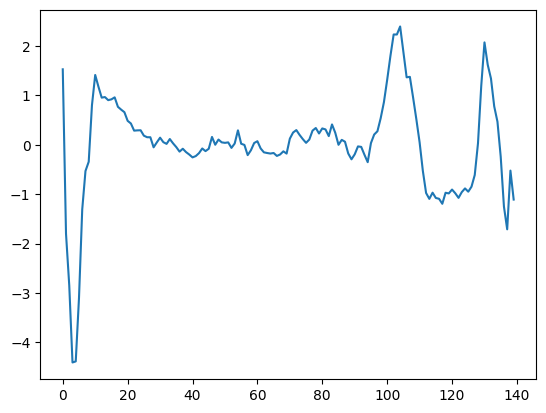

In [5]:
from preprocessing.augmentations import Augmenter

config = load_yaml_param_settings("configs/config.yaml")

aug = Augmenter(**config["augmentations"])

x, u = get_x_u()
xaugs = []

for _ in range(100):
    xaug, combination = aug.augment(x, return_combinations=True)
    xaugs.append(xaug)

plt.plot(x, label="original")

ValueError: num must be an integer with 1 <= num <= 12, not 13

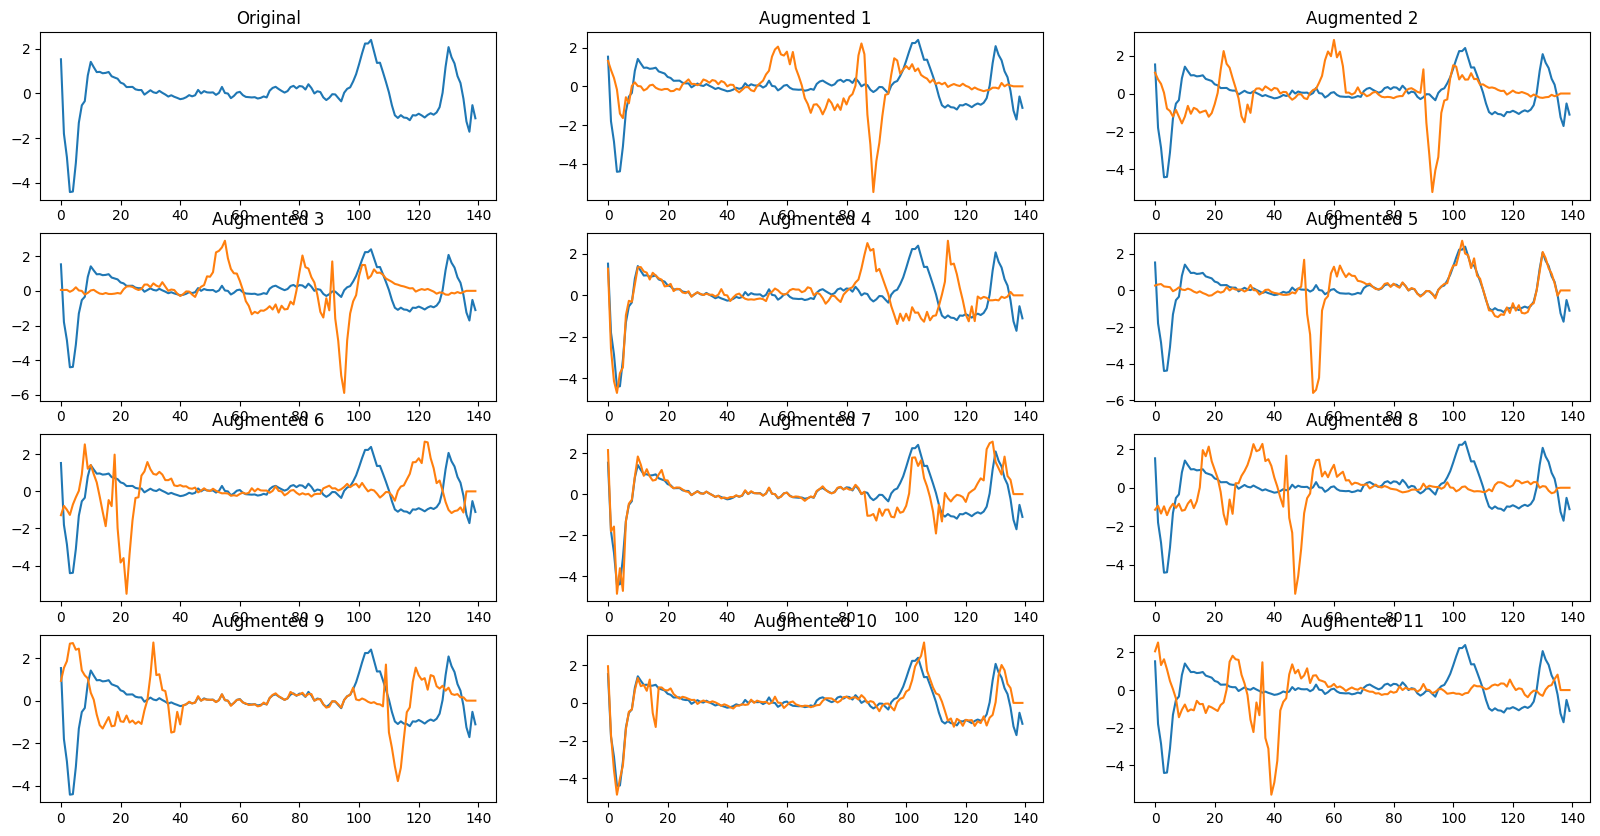

In [6]:
plt.figure(figsize=(20, 10))
plt.subplot(4, 3, 1)
plt.plot(x)
plt.title('Original')

# Plot augmented signals
for i in range(12):
    plt.subplot(4, 3, i+2)
    plt.plot(x, label='Original')
    xaug = aug.augment(x)
    plt.plot(xaug, label='Augmented')
    plt.title(f'Augmented {i+1}')

plt.tight_layout()
plt.show()#plot the original and augmented signals

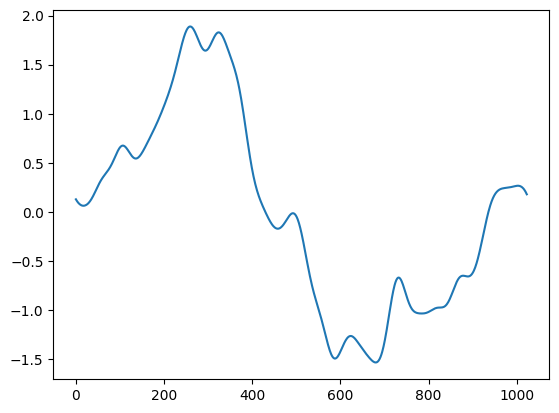

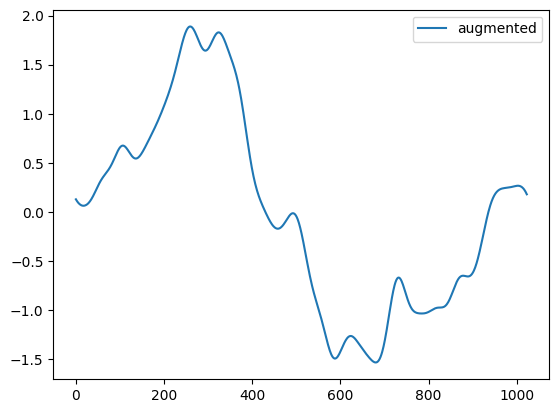

In [24]:
x, _ = get_x_u()
xaug = aug.augment(x)
plt.plot(x, label="original")
plt.show()
plt.close()
plt.plot(xaug, label="augmented")  # Include the augmented signal in the plot
plt.legend()
plt.show()#plot the original and augmented signals

In [25]:
def add_gaussian_noise(*subx_views, mean=0, variance=1.0):
    """
    Add Gaussian noise to the input sequences.
    """
    noise_subx_views = []

    for subx in subx_views:
        noise = np.random.normal(mean, np.sqrt(variance), subx.shape)
        noise_subx = subx + noise
        noise_subx_views.append(noise_subx)

    if len(noise_subx_views) == 1:
        noise_subx_views = noise_subx_views[0]

    return noise_subx_views

def add_slice_and_shuffle(*subx_views, n_segments=2):
    """
    Slice the input sequences into segments and shuffle them.
    """
    shuffled_subx_views = []

    for subx in subx_views:
        # Randomly pick n_segments-1 points where to slice
        idxs = np.random.randint(0, subx.shape[0], size=n_segments - 1)
        slices = []
        start_idx = 0
        for j in sorted(idxs):
            s = subx[start_idx:j]
            start_idx = j
            slices.append(s)
        slices.append(subx[start_idx:])
        np.random.shuffle(slices)
        shuffled_subx = np.concatenate(slices)
        shuffled_subx_views.append(shuffled_subx)

    if len(shuffled_subx_views) == 1:
        shuffled_subx_views = shuffled_subx_views[0]

    return shuffled_subx_views

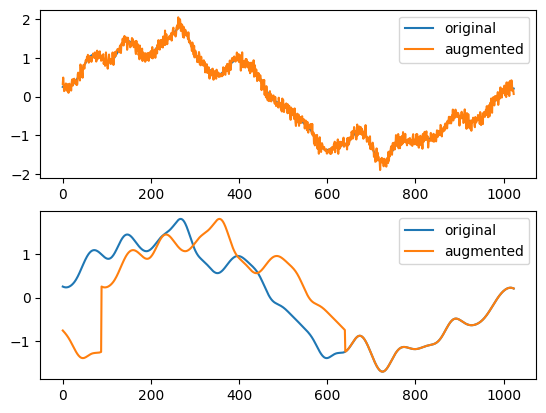

In [26]:
x, u = get_x_u()

aug_noise = add_gaussian_noise(x, mean=0, variance=0.01)
xaug_shuffled = add_slice_and_shuffle(x, n_segments=4)

f, a = plt.subplots(2)
a[0].plot(x, label="original")
a[0].plot(aug_noise, label="augmented")
a[0].legend()
a[1].plot(x, label="original")
a[1].plot(xaug_shuffled, label="augmented")
a[1].legend()
